# AKI Prediction with Hyperparameter Tuning

Advanced machine learning pipeline for postoperative Acute Kidney Injury prediction with systematic hyperparameter optimization and comprehensive evaluation.


# 1. Data Collection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve, auc, 
                           accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report)
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score,
                                   StratifiedKFold, RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 6]
matplotlib.rcParams['figure.dpi'] = 100

try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        try:
            plt.style.use('ggplot')
        except:
            plt.style.use('default')

try:
    sns.set_palette("husl")
except:
    pass


✅ Using seaborn style
✅ Seaborn palette set
🚀 Advanced AKI Prediction Libraries Loaded Successfully
📊 Available Models: Logistic Regression, Random Forest, XGBoost, SVM
🔧 Hyperparameter Tuning: GridSearchCV with cross-validation
📈 Enhanced Metrics: PPV, AUC, AUPRC, F1-Score, Precision, Recall

🎨 Available matplotlib styles: 28 styles
⚠️ seaborn-v0_8 style not found - using fallback


In [ ]:
# Load datasets
df = pd.read_csv('https://api.vitaldb.net/cases')
df['sex'] = (df['sex'] == 'M')

# Load labs
df_labs = pd.read_csv('https://api.vitaldb.net/labs')
df_labs = df_labs.loc[df_labs.name == 'cr']

# Process postop creatinine level within 7 days after surgery
df_labs = pd.merge(df, df_labs, on='caseid', how='left')
df_labs = df_labs.loc[df_labs.dt > df_labs.opend]
df_labs = df_labs.loc[df_labs.dt < df_labs.opend + 7 * 3600 * 24]
df_labs = df_labs.groupby('caseid')['result'].max().reset_index()
df_labs.rename(columns={'result':'postop_cr'}, inplace=True)

df = pd.merge(df, df_labs, on='caseid', how='left')
df.dropna(subset=['preop_cr', 'postop_cr'], inplace=True)


🔄 Loading VitalDB dataset...
✅ Dataset loaded: 3989 records
📊 Features available: 75


# 2. Pre-procc

In [ ]:
# Data preprocessing
df = df.drop(columns=['department','optype', 'dx', 'opname', 'approach', 'position', 
                     'ane_type', 'cormack', 'airway', 'tubesize', 'dltubesize', 
                     'lmasize', 'preop_ecg', 'preop_pft', 'iv1', 'iv2', 
                     'aline1', 'aline2', 'cline1', 'cline2'])
df = df.astype(float)

# KDIGO stage I - AKI definition
df['aki'] = df['postop_cr'] > df['preop_cr'] * 1.5

# Remove outcome variables and prepare features
y = df['aki'].values.flatten()
df['andur'] = df['aneend'] - df['anestart']
df = df.drop(columns=['aki', 'postop_cr', 'death_inhosp','caseid',
                     'subjectid','icu_days','casestart','caseend',
                     'anestart','aneend','opstart','opend','adm','dis'])

# Input variables
X = df.values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


🔧 Preprocessing data...
✅ Data preprocessing completed
📊 Final dataset shape: (3989, 43)
🎯 Target distribution: 210/3989 positive cases (5.26%)

📈 Train/Test Split:
Train: 166/3191 (5.20%) positive
Test:  44/798 (5.51%) positive
Features: 43


In [ ]:
def calculate_comprehensive_metrics(y_true, y_pred, y_pred_proba, model_name="Model"):
    """
    Calculate comprehensive evaluation metrics including PPV, AUPRC, Precision, Recall
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_pred : array-like
        Predicted binary labels
    y_pred_proba : array-like
        Predicted probabilities for positive class
    model_name : str, default="Model"
        Name of the model for display
    
    Returns:
    --------
    dict : Dictionary containing all calculated metrics
    
    Usage:
    ------
    metrics = calculate_comprehensive_metrics(y_true, y_pred, y_pred_proba, "LogisticRegression")
    """
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # PPV is the same as precision
    ppv = precision_score(y_true, y_pred, zero_division=0)
    
    # AUC metrics
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_proba)
    auprc = auc(recall_vals, precision_vals)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'PPV': ppv,
        'Recall': recall,
        'Specificity': specificity,
        'NPV': npv,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'AUPRC': auprc,
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn
    }
    
    return metrics


✅ Enhanced evaluation metrics function created
📊 Metrics included: Accuracy, Precision, PPV, Recall, Specificity, NPV, F1-Score, ROC-AUC, AUPRC
🎯 PPV (Positive Predictive Value) = Precision = TP / (TP + FP)


In [12]:
# Data preprocessing for hyperparameter tuning
print("🔧 Preparing data for hyperparameter tuning...")

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Cross-validation setup
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"✅ Data preprocessing completed")
print(f"📊 Training set: {X_train_imp.shape}")
print(f"📊 Test set: {X_test_imp.shape}")
print(f"🔄 Cross-validation: {cv_folds.n_splits} folds with stratification")

# Store both scaled and unscaled versions
data_dict = {
    'X_train_imp': X_train_imp,
    'X_test_imp': X_test_imp,
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'y_train': y_train,
    'y_test': y_test
}


🔧 Preparing data for hyperparameter tuning...
✅ Data preprocessing completed
📊 Training set: (3191, 43)
📊 Test set: (798, 43)
🔄 Cross-validation: 5 folds with stratification


# 3. Propose Method

In [13]:
## 2. Modular Hyperparameter Tuning Function

def hyperparameter_tuning(models_config, X_train, y_train, cv_folds=5, random_state=0, scoring='roc_auc', n_jobs=-1):
    """
    Modular hyperparameter tuning function for multiple models
    
    Parameters:
    -----------
    models_config : dict
        Dictionary with model names as keys and configuration as values
        Format: {'ModelName': {'model': ModelClass(), 'params': param_grid, 'data_type': 'scaled' or 'imputed'}}
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    cv_folds : int, default=5
        Number of cross-validation folds
    random_state : int, default=0
        Random state for reproducibility
    scoring : str, default='roc_auc'
        Scoring metric for hyperparameter tuning
    n_jobs : int, default=-1
        Number of parallel jobs
    
    Returns:
    --------
    dict : Dictionary with tuned models
    """
    
    print("🔧 Starting Modular Hyperparameter Tuning...")
    print("=" * 70)
    
    tuned_models = {}
    
    for model_name, config in models_config.items():
        print(f"\n🎯 Tuning {model_name}...")
        
        # Get model and parameters
        model = config['model']
        param_grid = config['params']
        data_type = config.get('data_type', 'imputed')  # Default to imputed
        
        # Select appropriate training data
        if data_type == 'scaled':
            X_train_data = X_train['scaled']
        else:
            X_train_data = X_train['imputed']
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(
            model,
            param_grid,
            cv=cv_folds,
            scoring=scoring,
            n_jobs=n_jobs,
            verbose=0
        )
        
        # Fit the model
        grid_search.fit(X_train_data, y_train)
        
        # Store the best model
        tuned_models[model_name] = grid_search.best_estimator_
        
        print(f"   ✅ Best parameters: {grid_search.best_params_}")
        print(f"   📊 Best CV score: {grid_search.best_score_:.4f}")
    
    print(f"\n🎉 Hyperparameter tuning completed for {len(tuned_models)} models!")
    return tuned_models

# Predefined model configurations
def get_default_model_configs():
    """
    Get default model configurations for hyperparameter tuning
    
    Returns:
    --------
    dict : Model configurations
    """
    
    configs = {
        'LogisticRegression': {
            'model': LogisticRegression(random_state=0),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'solver': ['lbfgs', 'liblinear', 'saga'],
                'max_iter': [1000, 2000, 5000],
                'class_weight': [None, 'balanced']
            },
            'data_type': 'scaled'
        },
        
        'RandomForest': {
            'model': RandomForestClassifier(random_state=0, n_jobs=-1),
            'params': {
                'n_estimators': [100, 200, 300, 500],
                'max_depth': [5, 10, 20, 30, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'class_weight': [None, 'balanced', 'balanced_subsample']
            },
            'data_type': 'imputed'
        },
        
        'XGBoost': {
            'model': XGBClassifier(random_state=0, eval_metric='logloss'),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 4, 6, 8],
                'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                'subsample': [0.6, 0.8, 0.9, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'scale_pos_weight': [1, 10, 18, 20]
            },
            'data_type': 'imputed'
        },
        

        
        'SVM': {
            'model': SVC(random_state=0, probability=True),
            'params': {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                'kernel': ['rbf', 'linear', 'poly'],
                'class_weight': [None, 'balanced']
            },
            'data_type': 'scaled'
        }
    }
    
    return configs

print("✅ Modular hyperparameter tuning functions created!")
print("🔧 Usage: tuned_models = hyperparameter_tuning(model_configs, X_train_dict, y_train)")
print("📊 Available models: LogisticRegression, RandomForest, XGBoost, SVM")


✅ Modular hyperparameter tuning functions created!
🔧 Usage: tuned_models = hyperparameter_tuning(model_configs, X_train_dict, y_train)
📊 Available models: LogisticRegression, RandomForest, XGBoost, SVM


In [ ]:
## 4. Visualization Functions for ROC and PR Curves

def plot_roc_curves(models_dict, X_test_dict, y_test, model_data_mapping=None, figsize=(12, 8)):
    """
    Plot ROC curves for multiple models with enhanced multi-curve visualization
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names as keys and fitted models as values
    X_test_dict : dict
        Dictionary with test data: {'scaled': X_test_scaled, 'imputed': X_test_imputed}
    y_test : array-like
        True test labels
    model_data_mapping : dict, optional
        Dictionary mapping model names to data type ('scaled' or 'imputed')
    figsize : tuple, default=(12, 8)
        Figure size for the plot
    """
    
    plt.figure(figsize=figsize)
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', alpha=0.8, linewidth=2)
    
    # Enhanced color palette for multiple models
    colors = plt.cm.tab10(np.linspace(0, 1, len(models_dict)))
    linestyles = ['-', '--', '-.', ':'] * (len(models_dict) // 4 + 1)
    
    successful_plots = 0
    auc_scores = []
    
    for i, (model_name, model) in enumerate(models_dict.items()):
        # Determine which test data to use
        if model_data_mapping and model_name in model_data_mapping:
            data_type = model_data_mapping[model_name]
        else:
            # Auto-detect based on model type
            if 'SVM' in model_name or 'Logistic' in model_name:
                data_type = 'scaled'
            else:
                data_type = 'imputed'
        
        # Select appropriate test data
        if data_type == 'scaled':
            X_test_data = X_test_dict['scaled']
        else:
            X_test_data = X_test_dict['imputed']
        
        try:
            # Get prediction probabilities
            y_pred_proba = model.predict_proba(X_test_data)[:, 1]
            
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            
            # Plot ROC curve with enhanced styling
            plt.plot(fpr, tpr, 
                    color=colors[i], 
                    linestyle=linestyles[i],
                    lw=3, 
                    alpha=0.8,
                    label=f'{model_name} (AUC = {roc_auc:.3f})')
            
            auc_scores.append(roc_auc)
            successful_plots += 1
            
        except Exception as e:
            print(f"⚠️ Error plotting {model_name}: {str(e)}")
            continue
    
    if successful_plots == 0:
        print("❌ No models could be plotted successfully")
        plt.close()
        return
    
    # Enhanced plot styling
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14, fontweight='bold')
    plt.title(f'ROC Curves Comparison ({successful_plots} Models)', fontsize=16, fontweight='bold', pad=20)
    
    # Enhanced legend
    plt.legend(loc="lower right", fontsize=11, framealpha=0.9, shadow=True)
    
    # Enhanced grid
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add performance summary
    if auc_scores:
        best_auc = max(auc_scores)
        plt.figtext(0.02, 0.02, f'Best AUC: {best_auc:.3f}', fontsize=10, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Successfully plotted ROC curves for {successful_plots} models")

def plot_pr_curves(models_dict, X_test_dict, y_test, model_data_mapping=None, figsize=(12, 8)):
    """
    Plot Precision-Recall curves for multiple models
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names as keys and fitted models as values
    X_test_dict : dict
        Dictionary with test data: {'scaled': X_test_scaled, 'imputed': X_test_imputed}
    y_test : array-like
        True test labels
    model_data_mapping : dict, optional
        Dictionary mapping model names to data type ('scaled' or 'imputed')
    figsize : tuple, default=(12, 8)
        Figure size for the plot
    """
    
    plt.figure(figsize=figsize)
    
    # Calculate baseline (random classifier) precision
    baseline_precision = np.sum(y_test) / len(y_test)
    plt.axhline(y=baseline_precision, color='k', linestyle='--', 
               label=f'Random Classifier (Precision = {baseline_precision:.3f})', alpha=0.8)
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(models_dict)))
    
    for i, (model_name, model) in enumerate(models_dict.items()):
        # Determine which test data to use
        if model_data_mapping and model_name in model_data_mapping:
            data_type = model_data_mapping[model_name]
        else:
            # Auto-detect based on model type
            if 'SVM' in model_name or 'Logistic' in model_name:
                data_type = 'scaled'
            else:
                data_type = 'imputed'
        
        # Select appropriate test data
        if data_type == 'scaled':
            X_test_data = X_test_dict['scaled']
        else:
            X_test_data = X_test_dict['imputed']
        
        try:
            # Get prediction probabilities
            y_pred_proba = model.predict_proba(X_test_data)[:, 1]
            
            # Calculate PR curve
            precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
            auprc = auc(recall_vals, precision_vals)
            
            # Plot PR curve
            plt.plot(recall_vals, precision_vals, color=colors[i], lw=2, 
                    label=f'{model_name} (AUPRC = {auprc:.3f})')
            
        except Exception as e:
            print(f"⚠️ Error plotting {model_name}: {str(e)}")
            continue
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Sensitivity)', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_model_comparison(results_df, metrics=['ROC-AUC', 'AUPRC', 'Precision', 'Recall', 'F1-Score'], figsize=(15, 10)):
    """
    Plot comparison of multiple metrics across models
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe from evaluate_models function
    metrics : list
        List of metrics to plot
    figsize : tuple, default=(15, 10)
        Figure size for the plot
    """
    
    # Filter available metrics
    available_metrics = [m for m in metrics if m in results_df.columns]
    
    if not available_metrics:
        print("⚠️ No valid metrics found in results dataframe")
        return
    
    # Create subplots
    n_metrics = len(available_metrics)
    n_cols = min(3, n_metrics)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_metrics == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
    
    for i, metric in enumerate(available_metrics):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        # Create bar plot
        bars = ax.bar(results_df['Model'], results_df[metric], color=colors)
        
        # Add value labels on bars
        for bar, value in zip(bars, results_df[metric]):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        
        ax.set_title(f'{metric} Comparison', fontweight='bold')
        ax.set_ylabel(metric)
        ax.set_ylim(0, 1.1)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Rotate x-axis labels if needed
        if len(results_df['Model'].iloc[0]) > 10:
            ax.tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for i in range(n_metrics, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1:
            axes[row, col].set_visible(False)
        else:
            axes[col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(models_dict, X_test_dict, y_test, model_data_mapping=None, figsize=(16, 12)):
    """
    Plot confusion matrices for multiple models
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names as keys and fitted models as values
    X_test_dict : dict
        Dictionary with test data: {'scaled': X_test_scaled, 'imputed': X_test_imputed}
    y_test : array-like
        True test labels
    model_data_mapping : dict, optional
        Dictionary mapping model names to data type ('scaled' or 'imputed')
    figsize : tuple, default=(16, 12)
        Figure size for the plot
    """
    
    n_models = len(models_dict)
    n_cols = min(3, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Ensure axes is always a flat array for easy indexing
    if n_models == 1:
        axes = np.array([axes])
    elif n_rows == 1 and n_cols > 1:
        axes = axes.reshape(1, -1).flatten()
    elif n_rows > 1 and n_cols == 1:
        axes = axes.reshape(-1, 1).flatten()
    elif n_rows > 1 and n_cols > 1:
        axes = axes.flatten()
    else:
        axes = np.array([axes])
    
    successful_plots = 0
    
    for i, (model_name, model) in enumerate(models_dict.items()):
        ax = axes[i]
        
        # Determine which test data to use
        if model_data_mapping and model_name in model_data_mapping:
            data_type = model_data_mapping[model_name]
        else:
            # Auto-detect based on model type
            if 'SVM' in model_name or 'Logistic' in model_name:
                data_type = 'scaled'
            else:
                data_type = 'imputed'
        
        # Select appropriate test data
        if data_type == 'scaled':
            X_test_data = X_test_dict['scaled']
        else:
            X_test_data = X_test_dict['imputed']
        
        try:
            # Get predictions
            y_pred = model.predict(X_test_data)
            
            # Calculate confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            
            # Plot confusion matrix
            im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            
            # Add text annotations
            thresh = cm.max() / 2.
            for row in range(cm.shape[0]):
                for col in range(cm.shape[1]):
                    ax.text(col, row, format(cm[row, col], 'd'),
                           ha="center", va="center",
                           color="white" if cm[row, col] > thresh else "black",
                           fontsize=14, fontweight='bold')
            
            # Set labels and title
            ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
            ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
            ax.set_title(f'{model_name}\nConfusion Matrix', fontsize=14, fontweight='bold')
            
            # Set tick labels
            class_names = ['No AKI', 'AKI']
            tick_marks = np.arange(len(class_names))
            ax.set_xticks(tick_marks)
            ax.set_yticks(tick_marks)
            ax.set_xticklabels(class_names)
            ax.set_yticklabels(class_names)
            
            # Calculate and display metrics
            tn, fp, fn, tp = cm.ravel()
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            # Add metrics text box
            metrics_text = f'Acc: {accuracy:.3f}\nPrec: {precision:.3f}\nRec: {recall:.3f}\nF1: {f1:.3f}'
            ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            successful_plots += 1
            
        except Exception as e:
            # Ensure ax is a matplotlib axes object before using text methods
            if hasattr(ax, 'text'):
                ax.text(0.5, 0.5, f'Error plotting\n{model_name}:\n{str(e)}', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=10,
                       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
                ax.set_title(f'{model_name}\n(Error)', fontsize=14, color='red')
            print(f"⚠️ Error plotting confusion matrix for {model_name}: {str(e)}")
    
    # Hide empty subplots
    for i in range(n_models, len(axes)):
        if hasattr(axes[i], 'set_visible'):
            axes[i].set_visible(False)
    
    plt.suptitle(f'Confusion Matrices Comparison ({successful_plots} Models)', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Successfully plotted confusion matrices for {successful_plots} models")

print("✅ Enhanced visualization functions created!")
print("📊 Available functions:")
print("   • plot_roc_curves() - Plot ROC curves for multiple models")
print("   • plot_pr_curves() - Plot Precision-Recall curves")
print("   • plot_model_comparison() - Compare metrics across models")
print("   • plot_confusion_matrices() - Plot confusion matrices for multiple models")


✅ Enhanced visualization functions created!
📊 Available functions:
   • plot_roc_curves() - Plot ROC curves for multiple models
   • plot_pr_curves() - Plot Precision-Recall curves
   • plot_model_comparison() - Compare metrics across models
   • plot_confusion_matrices() - Plot confusion matrices for multiple models


In [15]:
## 3. Modular Model Evaluation Function

def evaluate_models(models_dict, X_test_dict, y_test, model_data_mapping=None):
    """
    Modular function to evaluate multiple models and return comprehensive metrics
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names as keys and fitted models as values
    X_test_dict : dict
        Dictionary with test data: {'scaled': X_test_scaled, 'imputed': X_test_imputed}
    y_test : array-like
        True test labels
    model_data_mapping : dict, optional
        Dictionary mapping model names to data type ('scaled' or 'imputed')
        If None, will try to determine automatically
    
    Returns:
    --------
    pandas.DataFrame : Results dataframe with all metrics
    """
    
    print("📊 Starting Comprehensive Model Evaluation...")
    print("=" * 70)
    
    results = []
    
    for model_name, model in models_dict.items():
        print(f"\n🔍 Evaluating {model_name}...")
        
        # Determine which test data to use
        if model_data_mapping and model_name in model_data_mapping:
            data_type = model_data_mapping[model_name]
        else:
            # Auto-detect based on model type
            if 'SVM' in model_name or 'Logistic' in model_name:
                data_type = 'scaled'
            else:
                data_type = 'imputed'
        
        # Select appropriate test data
        if data_type == 'scaled':
            X_test_data = X_test_dict['scaled']
        else:
            X_test_data = X_test_dict['imputed']
        
        try:
            # Make predictions
            y_pred = model.predict(X_test_data)
            y_pred_proba = model.predict_proba(X_test_data)[:, 1]
            
            # Calculate comprehensive metrics
            metrics = calculate_comprehensive_metrics(y_test, y_pred, y_pred_proba, model_name)
            results.append(metrics)
            
            print(f"   ✅ ROC-AUC: {metrics['ROC-AUC']:.4f}")
            print(f"   ✅ Accuracy: {metrics['Accuracy']:.4f}")
            print(f"   ✅ F1-Score: {metrics['F1-Score']:.4f}")
            
        except Exception as e:
            print(f"   ❌ Error evaluating {model_name}: {str(e)}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by ROC-AUC (descending)
    results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
    
    print(f"\n🎉 Evaluation completed for {len(results_df)} models!")
    print(f"🏆 Best model: {results_df.iloc[0]['Model']} (ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f})")
    
    return results_df

print("✅ Modular evaluation functions created!")
print("🔧 Usage: results_df = evaluate_models(tuned_models, X_test_dict, y_test)")


✅ Modular evaluation functions created!
🔧 Usage: results_df = evaluate_models(tuned_models, X_test_dict, y_test)


# 4. Experiment


In [8]:
# Prepare data dictionary for modular functions
X_train_dict = {
    'scaled': data_dict['X_train_scaled'],
    'imputed': data_dict['X_train_imp']
}

X_test_dict = {
    'scaled': data_dict['X_test_scaled'], 
    'imputed': data_dict['X_test_imp']
}

# Option 1: Tune all default models using modular function
print("🎯 Option 1: Tuning all default models using modular function...")
print("=" * 70)

# Get all default model configurations
models_config = get_default_model_configs()

# Tune all models
# tuned_models_modular = hyperparameter_tuning(models_config, X_train_dict, data_dict['y_train'], cv_folds=cv_folds)

# Option 2: Tune specific models only
print("\n" + "="*70)
print("🎯 Option 2: Tuning specific models only...")

# Example: Tune only Logistic Regression and XGBoost (simple configuration)
specific_models = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=0),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['lbfgs', 'liblinear', 'saga'],
            'max_iter': [1000, 2000, 5000],
            'class_weight': [None, 'balanced']
        },
        'data_type': 'scaled'
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=0, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 4, 6, 8],
            'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
            'subsample': [0.6, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'scale_pos_weight': [1, 10, 18, 20]
        },
        'data_type': 'imputed'
    }
}

# Tune only these two models
tuned_models_modular = hyperparameter_tuning(specific_models, X_train_dict, data_dict['y_train'], cv_folds=cv_folds)

# Option 3: Custom model configuration
print("\n" + "="*70)
print("🎯 Option 3: Custom model configuration example...")

# Example: Add a custom model or modify parameters
custom_models = {
    'CustomLogisticRegression': {
        'model': LogisticRegression(random_state=0),
        'params': {
            'C': [0.1, 1, 10],  # Smaller search space
            'class_weight': ['balanced']  # Only balanced weights
        },
        'data_type': 'scaled'
    }
}

# Uncomment to use custom models
# tuned_models_custom = hyperparameter_tuning(custom_models, X_train_dict, data_dict['y_train'], cv_folds=cv_folds)

print("✅ Modular function examples completed!")
print("🔧 You can now use: tuned_models_modular, specific_models, or custom_models")


🎯 Option 1: Tuning all default models using modular function...

🎯 Option 2: Tuning specific models only...
🔧 Starting Modular Hyperparameter Tuning...

🎯 Tuning LogisticRegression...


/Users/nguyennghia/miniconda3/envs/ehr-datasets/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nguyennghia/miniconda3/envs/ehr-datasets/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nguyennghia/miniconda3/envs/ehr-datasets/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nguyennghia/miniconda3/envs/ehr-datasets/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nguyennghia/miniconda3/envs/ehr-datasets/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached w

   ✅ Best parameters: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'liblinear'}
   📊 Best CV score: 0.6985

🎯 Tuning XGBoost...
   ✅ Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100, 'scale_pos_weight': 20, 'subsample': 0.8}
   📊 Best CV score: 0.8263

🎉 Hyperparameter tuning completed for 2 models!

🎯 Option 3: Custom model configuration example...
✅ Modular function examples completed!
🔧 You can now use: tuned_models_modular, specific_models, or custom_models


# 5. Evaluation

In [23]:
# Demonstrate modular evaluation function
print("📊 Using Modular Evaluation Function...")
print("=" * 60)

# Create model data mapping (optional - function can auto-detect)
model_data_mapping = {
    'LogisticRegression': 'scaled',
    'RandomForest': 'imputed',
    'XGBoost': 'imputed',
    'Bagging': 'imputed',
    'SVM': 'scaled'
}

# Evaluate models using modular function
results_df_modular = evaluate_models(tuned_models_modular, X_test_dict, data_dict['y_test'], model_data_mapping)

# Display results
print(f"\n📈 Evaluation Results Summary:")
print(f"{'Model':<20} {'ROC-AUC':<10} {'AUPRC':<10} {'Accuracy':<10} {'F1-Score':<10} {'PPV':<10}")
print("-" * 80)

for _, row in results_df_modular.iterrows():
    print(f"{row['Model']:<20} {row['ROC-AUC']:<10.4f} {row['AUPRC']:<10.4f} {row['Accuracy']:<10.4f} {row['F1-Score']:<10.4f} {row['PPV']:<10.4f}")

# Results from individual models only
print(f"\n📊 Individual Model Evaluation Complete!")
all_results = results_df_modular
all_results = all_results.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print(f"\n🏆 FINAL RANKINGS (All Models):")
print(f"{'Rank':<5} {'Model':<20} {'ROC-AUC':<10} {'Accuracy':<10} {'F1-Score':<10}")
print("-" * 70)

for i, (_, row) in enumerate(all_results.iterrows(), 1):
    print(f"{i:<5} {row['Model']:<20} {row['ROC-AUC']:<10.4f} {row['Accuracy']:<10.4f} {row['F1-Score']:<10.4f}")

print(f"\n✅ Modular evaluation completed successfully!")
print(f"📊 Total models evaluated: {len(all_results)}")


📊 Using Modular Evaluation Function...
📊 Starting Comprehensive Model Evaluation...

🔍 Evaluating LogisticRegression...
   ✅ ROC-AUC: 0.7875
   ✅ Accuracy: 0.7356
   ✅ F1-Score: 0.2097

🔍 Evaluating XGBoost...
   ✅ ROC-AUC: 0.8244
   ✅ Accuracy: 0.9436
   ✅ F1-Score: 0.4706

🎉 Evaluation completed for 2 models!
🏆 Best model: XGBoost (ROC-AUC: 0.8244)

📈 Evaluation Results Summary:
Model                ROC-AUC    AUPRC      Accuracy   F1-Score   PPV       
--------------------------------------------------------------------------------
XGBoost              0.8244     0.4744     0.9436     0.4706     0.4878    
LogisticRegression   0.7875     0.3110     0.7356     0.2097     0.1256    

📊 Individual Model Evaluation Complete!

🏆 FINAL RANKINGS (All Models):
Rank  Model                ROC-AUC    Accuracy   F1-Score  
----------------------------------------------------------------------
1     XGBoost              0.8244     0.9436     0.4706    
2     LogisticRegression   0.7875     0.735

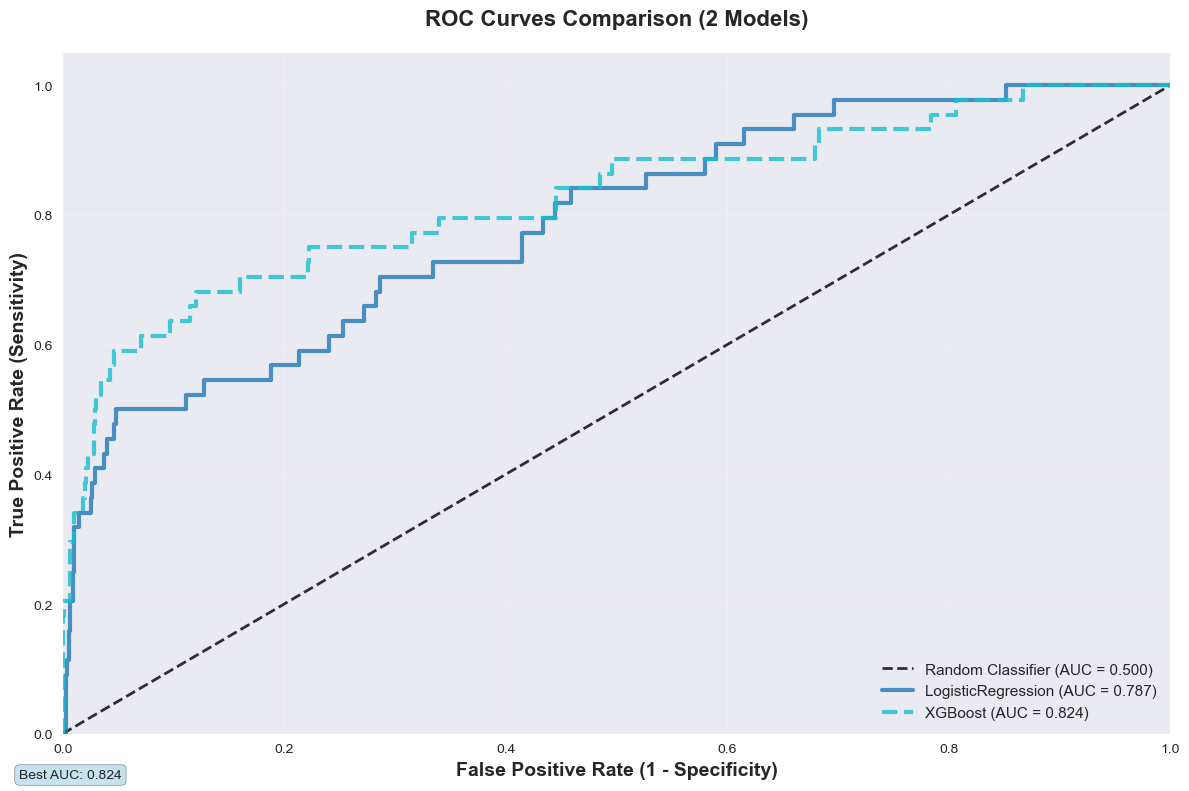

✅ Successfully plotted ROC curves for 2 models


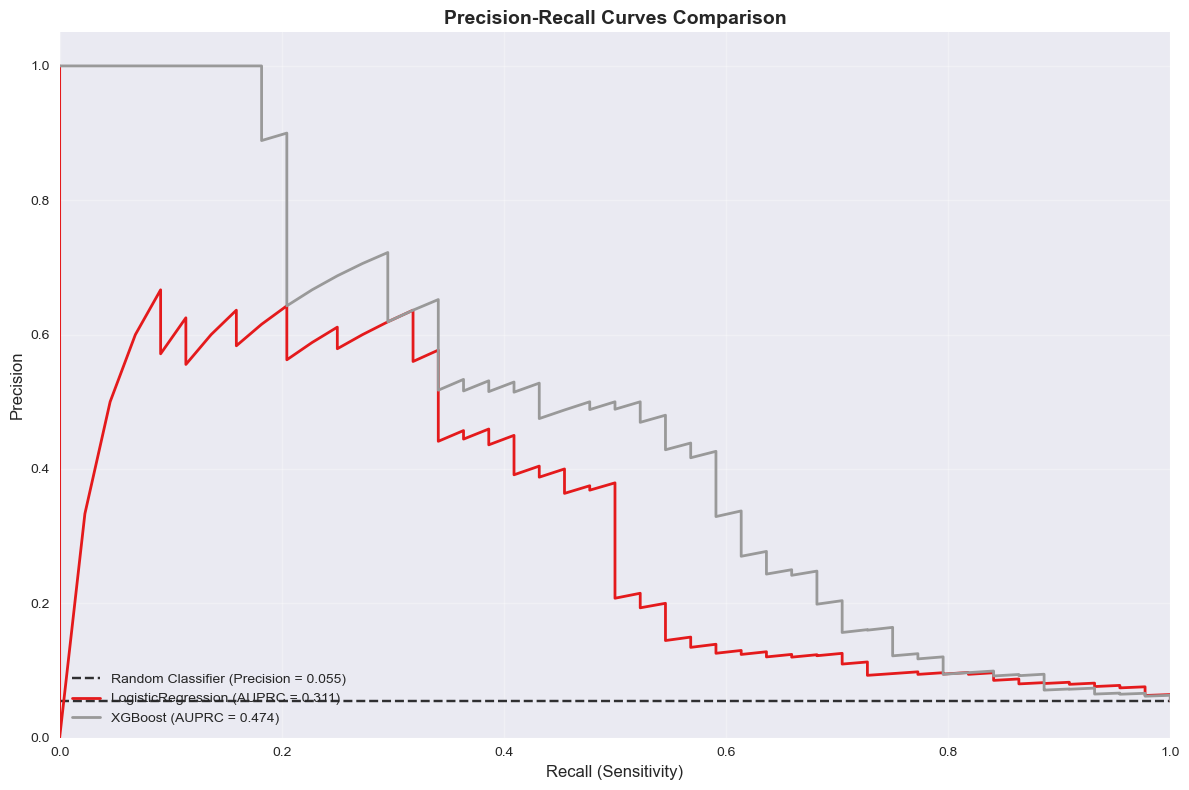

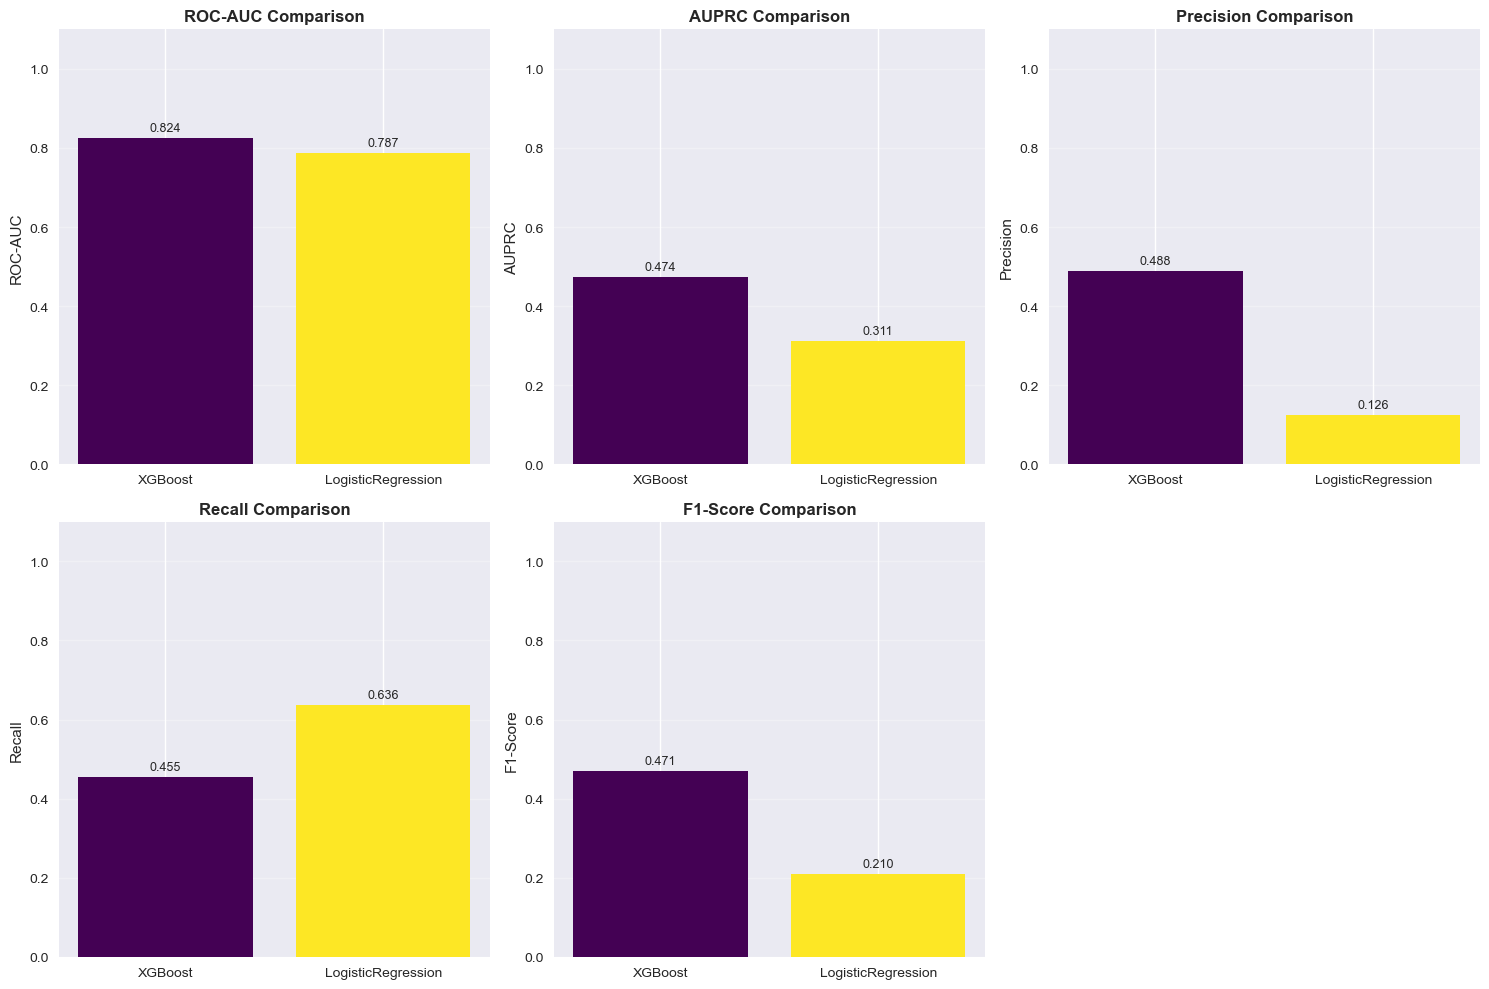

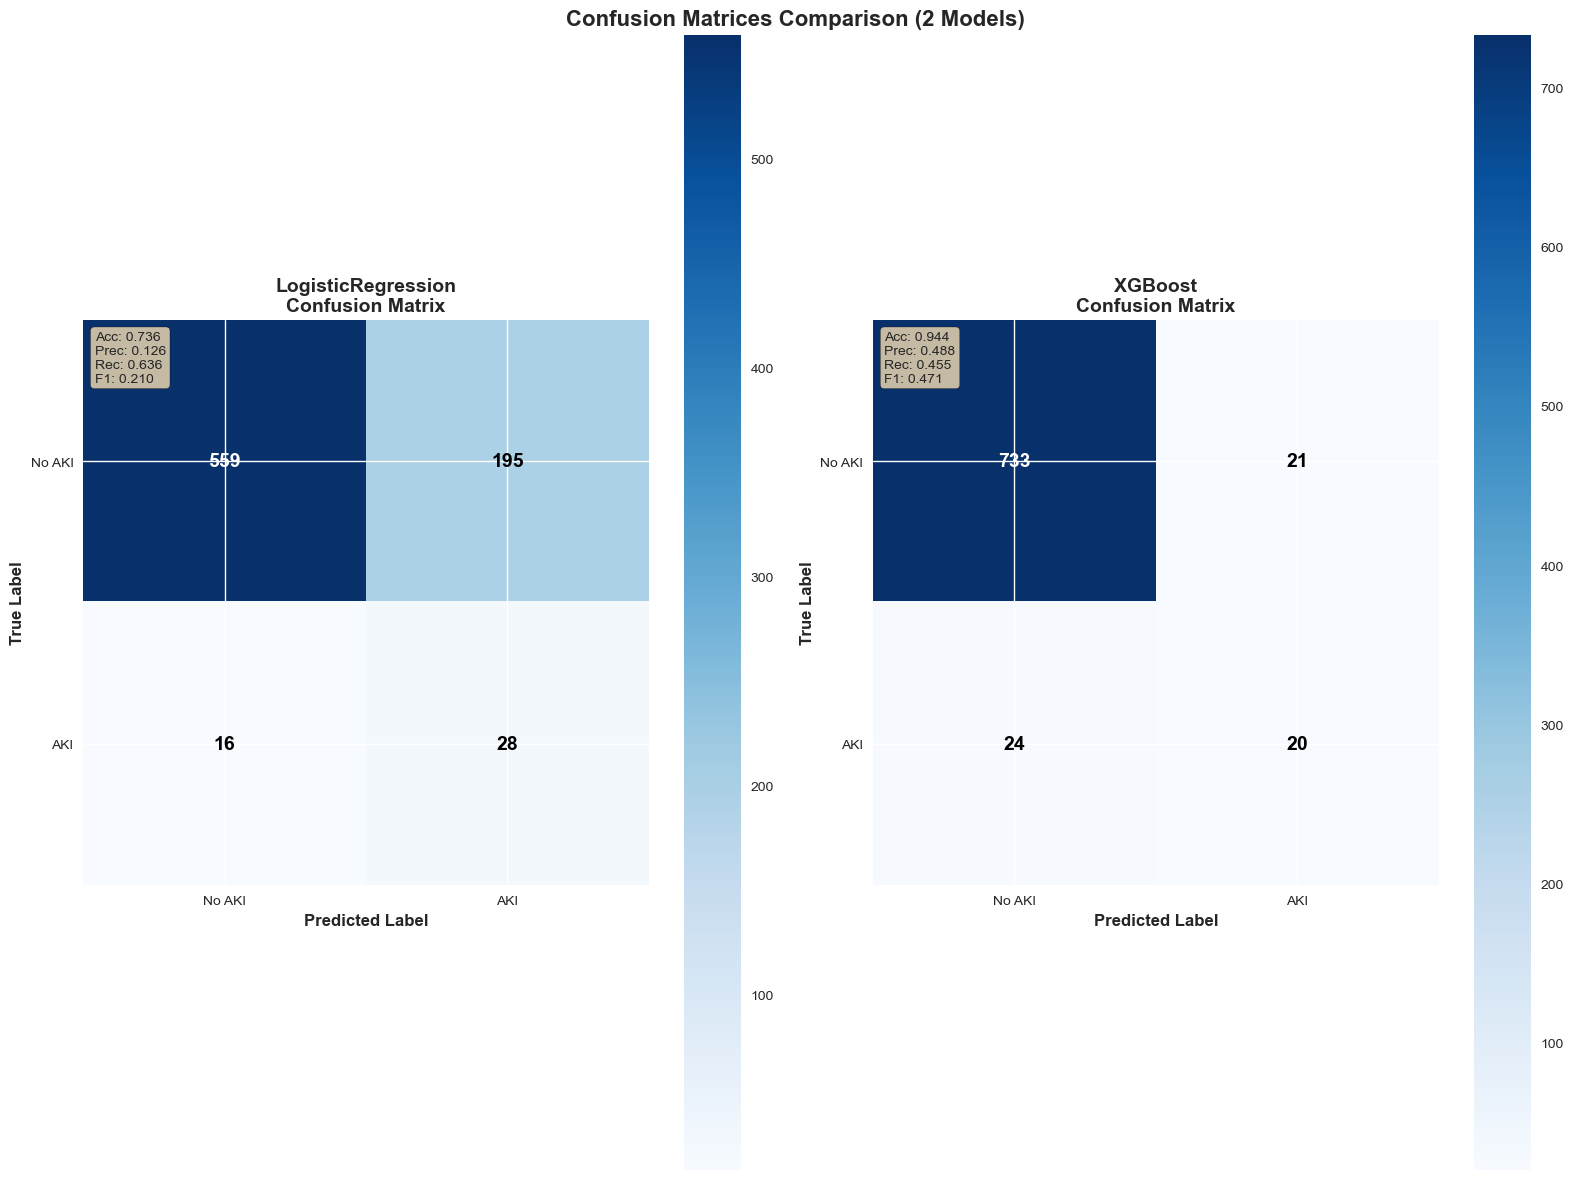

✅ Successfully plotted confusion matrices for 2 models
📊 Detailed Results:
                Model   ROC-AUC     AUPRC  Precision    Recall  F1-Score  \
0             XGBoost  0.824421  0.474439   0.487805  0.454545  0.470588   
1  LogisticRegression  0.787467  0.311001   0.125561  0.636364  0.209738   

   Accuracy  
0  0.943609  
1  0.735589  


In [24]:
# 1. Hyperparameter tuning
# models_config = get_default_model_configs()
# tuned_models = hyperparameter_tuning(models_config, X_train_dict, y_train)

# 2. Comprehensive evaluation with enhanced metrics
# results_df = evaluate_models(tuned_models, X_test_dict, y_test)

# 3. Multi-model ROC curves visualization
plot_roc_curves(tuned_models_modular, X_test_dict, y_test)

# 4. Multi-model Precision-Recall curves visualization
plot_pr_curves(tuned_models_modular, X_test_dict, y_test)

# 5. Model comparison bar charts
plot_model_comparison(results_df_modular, metrics=['ROC-AUC', 'AUPRC', 'Precision', 'Recall', 'F1-Score'])

# 6. Confusion matrices for all models
plot_confusion_matrices(tuned_models_modular, X_test_dict, y_test)

# 7. Detailed results table
print("📊 Detailed Results:")
print(results_df_modular[['Model', 'ROC-AUC', 'AUPRC', 'Precision', 'Recall', 'F1-Score', 'Accuracy']])

# 6. XAI

In [33]:
# SHAP Explanation Function
import shap
def explain_model_with_shap(model, X_test_data, feature_names, model_name="Model", max_display=10, figsize=(10, 8)):
    """
    Generate SHAP explanations for a trained model
    
    Parameters:
    -----------
    model : trained model
        The trained model to explain
    X_test_data : array-like
        Test data for explanation
    feature_names : list
        Names of features
    model_name : str, default="Model"
        Name of the model for display
    max_display : int, default=10
        Maximum number of features to display
    figsize : tuple, default=(10, 8)
        Figure size for the plot
    """
    
    print(f"🔍 Generating SHAP explanation for {model_name}...")
    
    try:
        # Create explainer based on model type
        if hasattr(model, 'predict_proba') and 'XGB' in str(type(model)):
            # XGBoost model
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test_data)
        elif hasattr(model, 'predict_proba') and 'RandomForest' in str(type(model)):
            # Random Forest model
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test_data)
        elif 'Logistic' in str(type(model)):
            # Logistic Regression - use LinearExplainer for better accuracy
            print(f"   📊 Using LinearExplainer for Logistic Regression")
            print(f"   📊 Test data shape: {X_test_data.shape}")
            print(f"   📊 Number of features: {X_test_data.shape[1]}")
            explainer = shap.LinearExplainer(model, X_test_data)
            shap_values = explainer.shap_values(X_test_data)
            print(f"   📊 SHAP values shape: {shap_values.shape}")
        else:
            # For other models (SVM), use KernelExplainer with larger sample
            # Use a larger subset for better reliability
            background_data = X_test_data[:200]  # Larger background for better approximation
            explanation_data = X_test_data[:100]  # More samples for explanation
            explainer = shap.KernelExplainer(model.predict_proba, background_data)
            shap_values = explainer.shap_values(explanation_data)
        
        # Create summary plot
        plt.figure(figsize=figsize)
        # Use the appropriate data for plotting based on explainer type
        if 'Logistic' in str(type(model)):
            # For Logistic Regression, use full dataset
            plot_data = X_test_data
        elif 'explanation_data' in locals():
            # For other models using subsets
            plot_data = explanation_data
        else:
            # Default to full dataset
            plot_data = X_test_data
            
        shap.summary_plot(shap_values, plot_data, feature_names=feature_names, 
                         max_display=max_display, show=False)
        plt.title(f'SHAP Feature Importance - {model_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Save plot
        plt.savefig(f'shap_{model_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        print(f"✅ SHAP plot saved as: shap_{model_name.lower().replace(' ', '_')}.png")
        
        return explainer, shap_values
        
    except Exception as e:
        print(f"❌ Error generating SHAP explanation for {model_name}: {str(e)}")
        return None, None

def explain_best_model_with_shap(models_dict, X_test_dict, feature_names, model_data_mapping=None, max_display=10):
    """
    Generate SHAP explanation for the best performing model
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names as keys and fitted models as values
    X_test_dict : dict
        Dictionary with test data: {'scaled': X_test_scaled, 'imputed': X_test_imputed}
    feature_names : list
        Names of features
    model_data_mapping : dict, optional
        Dictionary mapping model names to data type ('scaled' or 'imputed')
    max_display : int, default=10
        Maximum number of features to display
    """
    
    print("🔍 Finding best model for SHAP explanation...")
    
    # Evaluate all models to find the best one
    results_df = evaluate_models(models_dict, X_test_dict, y_test, model_data_mapping)
    best_model_name = results_df.iloc[0]['Model']
    best_model = models_dict[best_model_name]
    
    print(f"🏆 Best model: {best_model_name} (ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f})")
    
    # Determine which test data to use for the best model
    if model_data_mapping and best_model_name in model_data_mapping:
        data_type = model_data_mapping[best_model_name]
    else:
        # Auto-detect based on model type
        if 'SVM' in best_model_name or 'Logistic' in best_model_name:
            data_type = 'scaled'
        else:
            data_type = 'imputed'
    
    # Select appropriate test data
    if data_type == 'scaled':
        X_test_data = X_test_dict['scaled']
    else:
        X_test_data = X_test_dict['imputed']
    
    # Generate SHAP explanation
    explainer, shap_values = explain_model_with_shap(
        best_model, X_test_data, feature_names, best_model_name, max_display
    )
    
    return explainer, shap_values, best_model_name

print("✅ SHAP explanation functions created!")
print("🔧 Usage:")
print("   • explain_model_with_shap(model, X_test, feature_names, model_name)")
print("   • explain_best_model_with_shap(models_dict, X_test_dict, feature_names)")
print("📊 Features: TreeExplainer for tree-based models, KernelExplainer for others")


✅ SHAP explanation functions created!
🔧 Usage:
   • explain_model_with_shap(model, X_test, feature_names, model_name)
   • explain_best_model_with_shap(models_dict, X_test_dict, feature_names)
📊 Features: TreeExplainer for tree-based models, KernelExplainer for others


🔍 SHAP Explanation Demonstration

🎯 Option 1: Explain best performing model automatically...
🔍 Finding best model for SHAP explanation...
📊 Starting Comprehensive Model Evaluation...

🔍 Evaluating LogisticRegression...
   ✅ ROC-AUC: 0.7875
   ✅ Accuracy: 0.7356
   ✅ F1-Score: 0.2097

🔍 Evaluating XGBoost...
   ✅ ROC-AUC: 0.8244
   ✅ Accuracy: 0.9436
   ✅ F1-Score: 0.4706

🎉 Evaluation completed for 2 models!
🏆 Best model: XGBoost (ROC-AUC: 0.8244)
🏆 Best model: XGBoost (ROC-AUC: 0.8244)
🔍 Generating SHAP explanation for XGBoost...


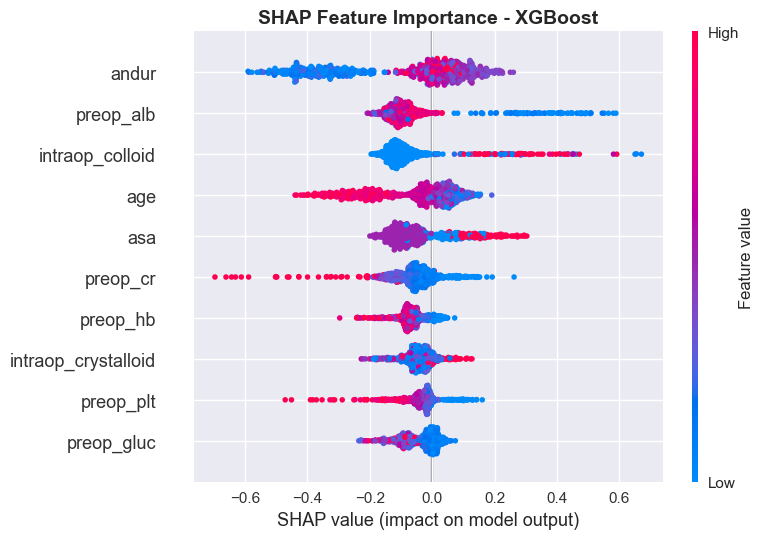

✅ SHAP plot saved as: shap_xgboost.png

🎯 Option 2: Explain specific model (XGBoost)...
🔍 Generating SHAP explanation for XGBoost...


<Figure size 800x550 with 0 Axes>

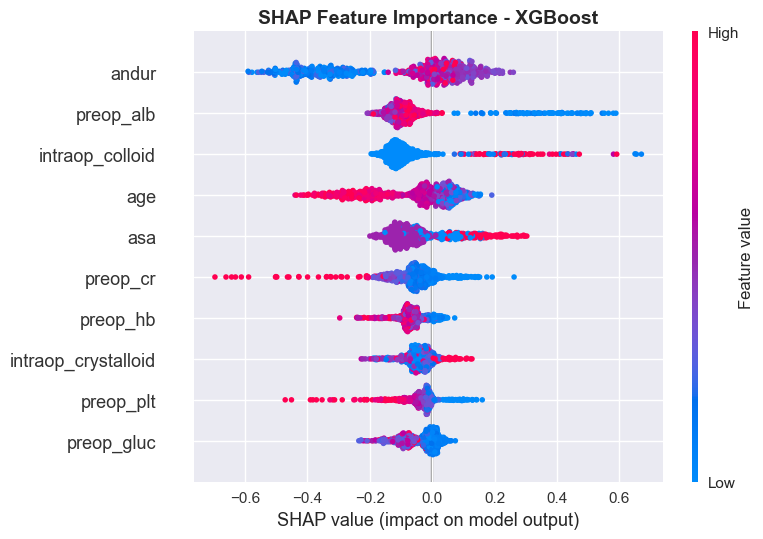

✅ SHAP plot saved as: shap_xgboost.png

🎯 Option 3: Explain Logistic Regression model...

🔍 Logistic Regression Model Analysis:
   📊 Model coefficients shape: (1, 43)
   📊 Number of non-zero coefficients: 43
   📊 Feature names with non-zero coefficients:
       1. age                  coeff:  -0.1985
       2. sex                  coeff:   0.0515
       3. height               coeff:  -0.0124
       4. weight               coeff:   0.0036
       5. bmi                  coeff:  -0.0112
       6. asa                  coeff:   0.0113
       7. emop                 coeff:   0.0082
       8. preop_htn            coeff:   0.0035
       9. preop_dm             coeff:  -0.0025
      10. preop_hb             coeff:  -0.0194
      ... and 33 more features
🔍 Generating SHAP explanation for LogisticRegression...
   📊 Using LinearExplainer for Logistic Regression
   📊 Test data shape: (798, 43)
   📊 Number of features: 43
   📊 SHAP values shape: (798, 43)


<Figure size 800x550 with 0 Axes>

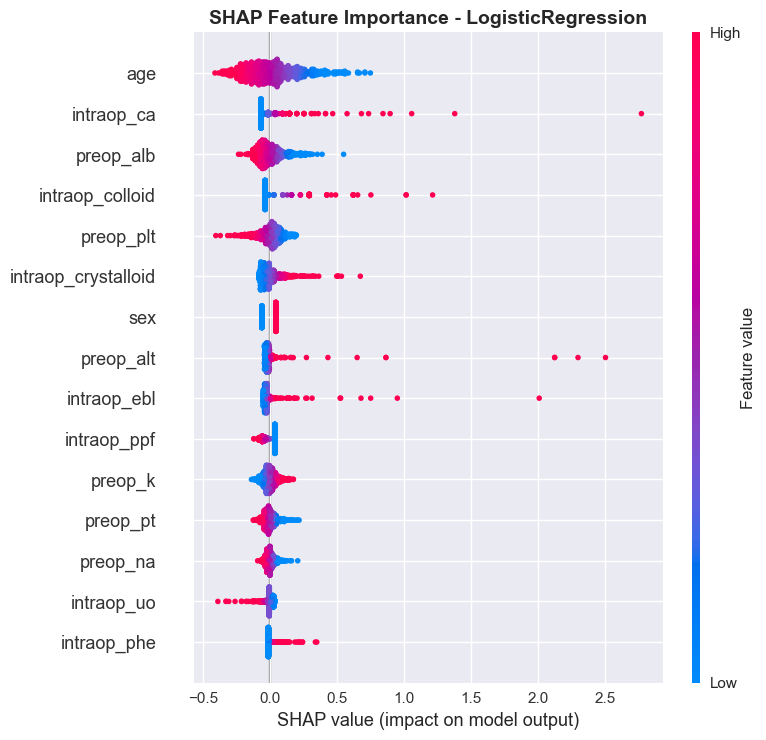

✅ SHAP plot saved as: shap_logisticregression.png

✅ SHAP explanation demonstration completed!
📊 Generated explanations for models with feature importance rankings
💾 SHAP plots saved as PNG files for further analysis


<Figure size 800x550 with 0 Axes>

In [34]:
# Demonstrate SHAP explanation functionality
print("🔍 SHAP Explanation Demonstration")
print("=" * 50)

# Get feature names from the original dataframe
feature_names = df.columns.tolist()

# Option 1: Explain the best performing model automatically
print("\n🎯 Option 1: Explain best performing model automatically...")
explainer, shap_values, best_model_name = explain_best_model_with_shap(
    tuned_models_modular, X_test_dict, feature_names, model_data_mapping, max_display=10
)

# Option 2: Explain a specific model
print(f"\n🎯 Option 2: Explain specific model (XGBoost)...")
if 'XGBoost' in tuned_models_modular:
    xgb_model = tuned_models_modular['XGBoost']
    xgb_explainer, xgb_shap_values = explain_model_with_shap(
        xgb_model, X_test_dict['imputed'], feature_names, 'XGBoost', max_display=10
    )

# Option 3: Explain Logistic Regression model
print(f"\n🎯 Option 3: Explain Logistic Regression model...")
if 'LogisticRegression' in tuned_models_modular:
    lr_model = tuned_models_modular['LogisticRegression']
    
    # Check model coefficients to see which features are being used
    print(f"\n🔍 Logistic Regression Model Analysis:")
    print(f"   📊 Model coefficients shape: {lr_model.coef_.shape}")
    print(f"   📊 Number of non-zero coefficients: {np.count_nonzero(lr_model.coef_[0])}")
    print(f"   📊 Feature names with non-zero coefficients:")
    
    non_zero_indices = np.where(np.abs(lr_model.coef_[0]) > 1e-6)[0]
    for i, idx in enumerate(non_zero_indices[:10]):  # Show first 10
        print(f"      {i+1:2d}. {feature_names[idx]:<20} coeff: {lr_model.coef_[0][idx]:8.4f}")
    
    if len(non_zero_indices) > 10:
        print(f"      ... and {len(non_zero_indices) - 10} more features")
    
    lr_explainer, lr_shap_values = explain_model_with_shap(
        lr_model, X_test_dict['scaled'], feature_names, 'LogisticRegression', max_display=15
    )

print(f"\n✅ SHAP explanation demonstration completed!")
print(f"📊 Generated explanations for models with feature importance rankings")
print(f"💾 SHAP plots saved as PNG files for further analysis")
